## DFT TESTBENCH

This notebook takes two inputs (real and imaginary) and gived the real and imaginary parts of the DFT outputs using AXI-STREAM. It is then compared with software version of FFT

In [2]:
import numpy as np
from pynq import allocate
from pynq.lib import dma
from scipy.linalg import dft
import matplotlib.pyplot as plt

In [3]:
from pynq import Overlay
ol=Overlay('design_1.bit')
ol.ip_dict
dma1=ol.axi_dma_0
dma2=ol.axi_dma_1

In [4]:
ol.ip_dict.keys()


dict_keys(['dft_0', 'axi_dma_0', 'axi_dma_1', 'processing_system7_0'])

In [5]:
NUM_SAMPLES = 1024

real_error=np.zeros(NUM_SAMPLES)
imag_error=np.zeros(NUM_SAMPLES)
ind=np.arange(NUM_SAMPLES)
real_rmse=np.zeros(NUM_SAMPLES)
imag_rmse=np.zeros(NUM_SAMPLES)

In [6]:
in_r = allocate(shape=(NUM_SAMPLES,), dtype=np.float32) 
in_i = allocate(shape=(NUM_SAMPLES,), dtype=np.float32)           
out_r = allocate(shape=(NUM_SAMPLES,), dtype=np.float32) 
out_i = allocate(shape=(NUM_SAMPLES,), dtype=np.float32)
a = [i for i in range(NUM_SAMPLES)]
a=np.cos(a)
real=a.real                # Change input real and imaginary value here
img=a.imag
np.copyto(in_r, real)
np.copyto(in_i, img)
in_r.flush()
in_i.flush()

In [7]:

dft_ip = ol.dft_0
dma2.recvchannel.start()
dma2.sendchannel.start()                # Start the DMA send and recv channels.
dma1.recvchannel.start()
dma1.sendchannel.start()

dma2.recvchannel.transfer(out_i)        #Send and recv data 
dma2.sendchannel.transfer(in_i)
dma1.recvchannel.transfer(out_r)
dma1.sendchannel.transfer(in_r)
dft_ip.write(0x00,1)

dma2.recvchannel.wait()
dma2.sendchannel.wait()                # Wait for the DMA to send and recv data.
dma1.recvchannel.wait()
dma1.sendchannel.wait()


In [8]:
dma1.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=1, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=1, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=361013248),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=4096),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=1, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGS

## Verifying Functionality 

In [9]:
golden_op=np.fft.fft(a)

for i in range(NUM_SAMPLES):

    real_error[i]="{0:.6f}".format(abs(out_r[i]-golden_op.real[i]))
    imag_error[i]="{0:.6f}".format(abs(out_i[i]-golden_op.imag[i]))

In [10]:
sum_sq_real=0
sum_sq_imag=0
for i in range(NUM_SAMPLES):
    sum_sq_real =sum_sq_real+(real_error[i]*real_error[i])
    real_rmse = np.sqrt(sum_sq_real / (i+1))
    sum_sq_imag =sum_sq_imag+(imag_error[i]*imag_error[i])
    imag_rmse = np.sqrt(sum_sq_imag / (i+1))
print("Real Part RMSE: ", real_rmse, "Imaginary Part RMSE:", imag_rmse)    
if real_rmse<0.001 and imag_rmse<0.001:
    print("PASS")
else:
    print("FAIL")

Real Part RMSE:  1.2013298295534854e-05 Imaginary Part RMSE: 4.895988472719265e-06
PASS


## Displaying Error and Output

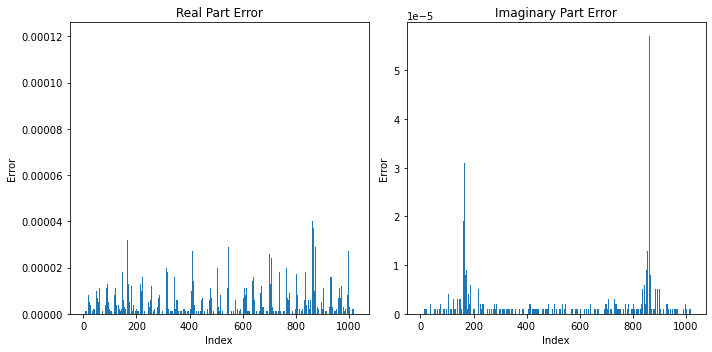

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,real_error)
plt.title("Real Part Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,imag_error)
plt.title("Imaginary Part Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

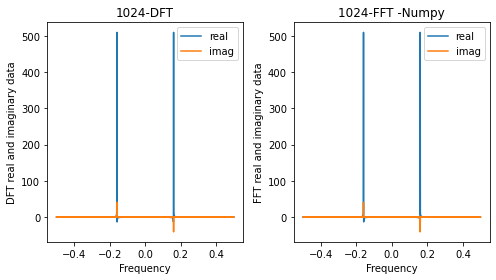

In [12]:
freq=np.fft.fftfreq(1024)

plt.figure(figsize=(7, 4))
plt.subplot(1,2,1)
plt.plot(freq,out_r,label='real')
plt.plot(freq,out_i,label='imag')
plt.title("1024-DFT")
plt.xlabel("Frequency")
plt.ylabel("DFT real and imaginary data")
plt.legend()
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(freq,golden_op.real,label='real')
plt.plot(freq,golden_op.imag,label='imag')
plt.title("1024-FFT -Numpy")
plt.xlabel("Frequency")
plt.ylabel("FFT real and imaginary data")
plt.legend()
plt.tight_layout()
plt.show()